# It's sampling all the way down:

## Understanding the Metropolis-Hastings algorithm

![evolution](./images/seashell.jpg)

# First of all, what is MCMC?

> Markov Chain Monte Carlo (MCMC) is a class of algorithm for sampling from a probability distribution based on constructing a Markov chain that has the desired distribution as its equilibrium distribution. The state of the chain after a number of steps is then used as a sample of the desired distribution. The quality of the sample improves as a function of the number of steps.

# Why is it useful?

MCMC algorithms are extremely useful in a number of situations, including:
* Calculating numerical approximations of multi-dimensional integrals, for example in Bayesian statistics, computational physics, computational biology and computational linguistics.
* In Bayesian statistics, the recent development of MCMC methods has been a key step in making it possible to compute large hierarchical models that require integrations over hundreds or even thousands of unknown parameters.
* They are also used for generating samples that gradually populate the rare failure region in rare event sampling.

![yay](./images/raw.gif)

# Quick example 1: the "intractable" integral

We all learned how to compute an integral in a Calculus class, however in the real world sometimes you happen to have to compute very complicated integrals which are not tractable. For instance, the computations required to calculate the Bayesian marginal likelihood for Mixture of Gaussians are exponential in number of data points:

$$
p(y_1, \dots, y_{N}) = \sum_{s_{1}} \sum_{s_{2}} \dots \sum_{s_{N}} \int p(\theta) \prod_{i = 1}^{N} p(y_{i} | s_{i}, \theta) p(s_{i} | \theta) d\theta
$$


How do we compute this integral if it is intractable?
* [Numerical integration](https://en.wikipedia.org/wiki/Numerical_integration) (Quadrature).
  * May not work if there are many parameters.
* Monte Carlo integration.

# The Metropolis-Hastings algorithm: the mother of all MCMC algorithms

In statistics and in statistical physics, the Metropolis–Hastings (MH) algorithm is a Markov Chain Monte Carlo method for obtaining a sequence of random samples from a probability distribution for which direct sampling is difficult. This sequence can be used to approximate the distribution or to compute an integral.

The MH algorithm can draw samples from any probability distribution $P(x)$, provided you can compute the value of a target function $f(x)$ – also called target distribution – that is proportional to the density of $P$.

The loose requirement that $f(x)$ should be merely proportional to the density, rather than exactly equal to it, makes the MH algorithm particularly useful, because calculating the necessary normalization factor is often extremely difficult in practice.

Very popular MCMC algorithms like Gibbs and Hamiltonian Monte Carlo are generalisations of Metropolis-Hastings. We will cover them in a future article.

# Why MH is so damn useful in Bayesian Inference?

When performing Bayesian inference, we aim to compute and use the full posterior joint distribution over a set of random variables ($\theta$). Remember the Bayes Theorem: 

$$
\begin{align*}
P(\theta | X) &= \frac{P(X | \theta) P(\theta)}{P(X)} \\
&= \frac{P(X | \theta) P(\theta)}{\int P(X | \theta) P(\theta) d\theta}
\end{align*}
$$

Unfortunately, this often requires calculating intractable integrals (the denominator in the above equation, also called the marginal likelihood, a.k.a. evidence), especially when dealing with Hierarchical models or large multi-dimensional and continuous problem spaces.

In such cases, we may give up on solving the analytical equations and proceed with sampling techniques based upon MCMC methods, such as MH. When using MCMC methods, we estimate the posterior distribution and the intractable integrals using simulated samples from the un-normalised posterior distribution.	

$$
\begin{align*}
P(\theta | X) &= \frac{P(X | \theta) P(\theta)}{P(X)} \\
&\propto P(X | \theta) P(\theta)
\end{align*}
$$

# This is all very interesting, but how does MH work?

The algorithm is quite simple:
* Generate a sequence of sample values in such a way that, as more sample values are produced, the distribution of values more closely approximates the desired distribution, $P(x)$.
* Sample values are produced iteratively, with the distribution of the next sample being dependent only on the current sample value (Markov Chain).
* At each iteration, the algorithm picks a candidate for the next sample value based on the current sample value, $q(x_{i} | x_{i - 1})$. Then, with some probability, the candidate is either accepted or rejected.
* The probability of acceptance is determined by comparing the values of the function $f(x)$ of the current and candidate sample values with respect to the desired distribution $P(x)$.

# Hmm, you lost me... Show me some pseudo code!

<img src="./images/metropolis-pseudo-code.png" alt="Drawing" style="width: 700px;"/>

# Looking under the hood

The pseudo code above should give a better idea of the procedure. We start from a random point in the target distribution, then iteratevely select a new candidate point from the same distribution which could be either accepted or rejected based on an acceptance function. The procedure last for as many iterations as the user decided to set when launching the routine.

# The proposal distribution

* In Metropolis–Hastings the proposal distribution is usually symmetric, meaning that $q(x_{i} |x_{i - 1}) = q(x_{i - 1} | x_{i})$.
  * A very common choice for the proposal distribution is a Gaussian centred at the current position.
  * The variance of the proposal distribution ($\sigma^{2}$, in case of a Gaussian) directly affects the acceptance rate.
* Asymmetric proposal distributions are also possible, i.e. log-normal.

An obvious drawback of MH is that some tuning might be required to obtain the best performance. This is particularly true in the real world since we would like to converge to a solution in the smallest amount of iterations as possible. If the variance of the proposal distribution is too large we might in fact have a small Effective Sample Size (ESS), meaning that most proposed points have been rejected. On the other hand, setting a small variance in the proposal distribution would generate points very close to the current position, thus require a large number of iterations before we can explore the entire posterior density.

Tuning the proposal distribution while running the algorithm is also not reccommended.

# The acceptance function

Every move proposed by the proposal function is carefully evaluated. If density at the candidate point is higher compared to the current position, the algorithm accepts the candidate point, which becomes the new position. If the density at the candidate point is  lower instead, the acceptance of the new point is proportional to the ratio between the proposal density and the current one. This mean that the algorithm will always prefer to move to areas of the posterior density which are more likely, but at the same time explore areas where less density is concentrated. This is different from pure optimisation procedures.

In the MH algorithm there is a fine balance between:
  * Visit areas with higher probability under the full joint density, constraint given by $\frac{\pi(x_{cand})}{\pi(x_{i - 1})}$
  * Explore the space and avoid getting stuck at one point, constraint given by $\frac{q(x_{i - 1} | x_{cand})}{q(x_{cand} | x_{i - 1})}$

The acceptance function must satisfy the condition of *detailed balance*, thus guarantees that the stationary distribution of the MH algorithm is the target posterior. We will explain what this means very soon. Stay tuned!

# Convergence

> Some people speak of the Markov chain itself converging. It doesn’t. The estimates using the Markov chain may converge. Speaking about the chain converging may just be using informal language, or it may betray a lack of understanding. 

Usually it's not hard to construct a Markov chain with the desired properties. The more difficult problem is to determine how many steps are needed to converge to the stationary distribution within an acceptable error. A good chain will have rapid mixing: the stationary distribution is reached quickly starting from an arbitrary position. A standard empirical method to assess convergence is to run several independent simulated Markov chains and check that the ratio of inter-chain to intra-chain variances for all the parameters sampled is close to 1.

Typically, MCMC sampling can only approximate the target distribution, as there is always some residual effect of the starting position. More sophisticated MCMC-based algorithms such as coupling from the past can produce exact samples, at the cost of additional computation and an unbounded (though finite in expectation) running time.

Many random walk Monte Carlo methods move around the equilibrium distribution in relatively small steps, with no tendency for the steps to proceed in the same direction. These methods are easy to implement and analyze, but unfortunately it can take a long time for the walker to explore all of the space. The walker will often double back and cover ground already covered.

* Exclude *burn-in* (also called *warm-up*).
* Thinning could be required when samples show high auto-correlation.
* Effective sample size is computed as: $\texttt{chains * ((iter - warmup) / thin)}$.

# Statistical properties, aka "Why does it work?"

Until now we stated the mechanics of the MH algorithm, without delving into the statistical properties that make the procedure succeed. MH satisfies two main properties, which guarantee that the equilibrium distribution equals to the desired distribution:
* *Ergodicity*, which means that every state can eventually reach any other state
* *Detailed balance*, if the transition rates between all states are zero when the sample has reached the correct probability distribution

# A Python implementation

I strongly believe that if you're not able to build something yourself, most likely you don't fully understand the concept you're trying to learn. This is particularly true in programming and mathematics. It took me a few days to been able to get a working implementation of the MH algorithm, sign that it wasn't as straightforward as I thought it would be. 

Anyway, there you go.. my implementation! If you're interesting in unit tests and that sort of things, have a look at [this public repository](https://github.com/IamGianluca/algorithms) where I collect some algorithms I've implemented. I promise I'll become more juicy over the next few months.

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 

In [1]:
class MetropolisHastings:

    def __init__(self, target, data, iterations=1000):
        # TODO: we shouldn't pass the data, since this is implementation
        # specific (bayesian model).
        # TODO: find a way to extract the number of dimension from the
        # target distribution?
        self.target = target
        self.data = data  # will be deprecated in next version
        self.iterations = iterations
        self.shape = data.shape
        self.traces = []

    def optimise(self):
        current_position = self._random_initialisation()
        for iteration in range(self.iterations):
            proposal = self._suggest_move(current_position=current_position)
            if self._evaluate_proposal(current_position, proposal):
                current_position = proposal
            self.traces.extend([current_position])
        return self.traces

    def _random_initialisation(self):
        # TODO: make sure point is within function domain, maybe use numpy.random.choice()
        return np.random.rand(self.shape[0])

    def _suggest_move(self, current_position):
        # TODO: avoid extra two steps, set centre to current position
        # TODO: make proposal distribution an optional argument
        jump = np.random.randn(self.shape[0])
        return np.sum([current_position, jump], axis=0)

    def _evaluate_proposal(self, current, proposal):
        # NOTE: for numerical computation stability we are using the 
        # logpdf instead of pdf. Using pdf the proposal would be accepted with
        # a probability equal to min(1, pdf_proposal / pdf_current).
        acceptance_probability = min(
            np.exp(self.target.logpdf(x=proposal) - \
                   self.target.logpdf(x=current)),
            1
        )
        u = np.random.uniform()
        return u < acceptance_probability

Now that we have a working implementation of the MH algorithm, we might want to test it using some synthetic dataset and an interesting desired distribution. Let's start with a simple univariate Normal distribution, and then move to multiple dimensions.

# Quick example 2: Univariate Gaussian distribution

Let's use the probability density function of the normal distribution:

$$f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{-(x - \mu)^{2}}{2\sigma^{2}}}$$

In [25]:
# create fake data (only useful in a bayesian context)
new_data = np.random.normal(loc=0, scale=1, size=1)
new_data

array([-0.13712472])

In [26]:
# create target distribution; in a bayesian model it will be (prior * likelihood)
target = stats.norm(loc=0, scale=1) 

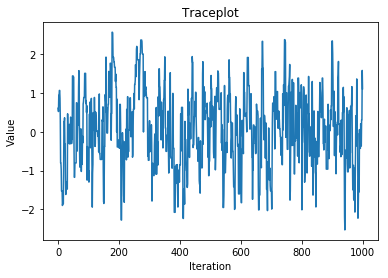

In [27]:
sampler = MetropolisHastings(target=target, data=new_data, iterations=1000)
samples = sampler.optimise()

plt.plot(samples)
plt.title('Traceplot')
plt.xlabel('Iteration'); plt.ylabel('Value')
plt.show()

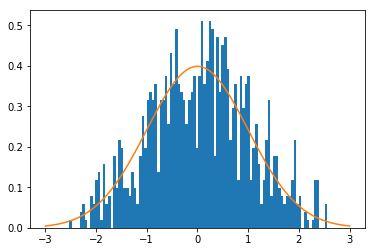

In [28]:
sample = [sample[0] for sample in samples]
plt.hist(sample, bins=100, normed=True)

import matplotlib.mlab as mlab
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(-3, 3, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.show()

# Quick example 3: Multivariate Gaussian distribution

In two dimensions, the circular Gaussian function is the distribution function for uncorrelated variates $X$ and $Y$ having a bivariate normal distribution and equal standard deviation $\sigma=\sigma_x=\sigma_y$:

$$f(x, y) = \frac{1}{2 \pi \sigma^2} e^{\frac{- \left[(x - \mu_{x})^{2} + (y - \mu_{y})^{2}   \right]}{2 \sigma^{2}}}$$

In the example below we are going even further and use a 5-D multivariate Gaussian distribution. The goal is again to reconstruct the desired distribution, efficiently sampling from it.

In [29]:
# create multivariate gaussian distribution
dimensions = 5
target = stats.multivariate_normal(mean=np.array([1, 2, 3, 4, 20]),
                                   cov=np.eye(dimensions))

# create a fake 5-D dataset (deprecated in future version)
new_data = np.random.multivariate_normal(np.zeros(dimensions), np.eye(dimensions))
new_data

array([ 1.79672289,  0.12842242,  0.8878671 ,  2.82876943,  1.06301454])

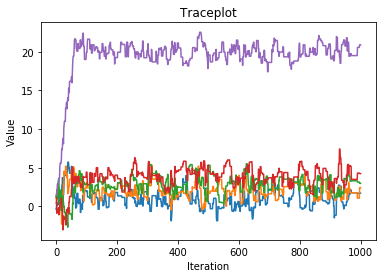

In [30]:
sampler = MetropolisHastings(target=target, data=new_data, iterations=1000)
samples = sampler.optimise()


plt.plot(samples)
plt.title('Traceplot')
plt.xlabel('Iteration'); plt.ylabel('Value')
plt.show()

What's interesting about this example is the 5th dimension (purple line). The mean of that distribution is quite far from the starting point, which means that the algorithm has a long way before being able to reach the area where the majority of the density is located.

It's also important to note how important is to use a `warm-up` period in such situations. This per se wouldn't be a problem if we were able to let the Markov chain to continue for a reasonably long time. It's however very important is cases where the number of iterations is small (like in our case, where we set only $1000$ samples) and when the variance in the proposal distribution is relatively small compared to the domain of the function we want to investigate.

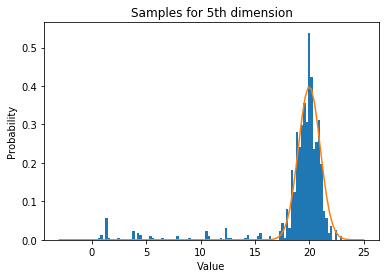

In [23]:
fifth_dimension = [sample[4] for sample in samples]

# sampled
plt.figure()
plt.hist(fifth_dimension, bins=100, normed=True)

# theoretical density distribution
mu = 20
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(-3, 25, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))

plt.title('Samples for 5th dimension')
plt.xlabel('Value'); plt.ylabel('Probability')
plt.show()

From the graph above it's clear how the left tail is over-represented because of the starting point is far from the area where most of the density lies. Given enough samples however, this is not a problem (feel free to clone the repository and play with it).

# Quick example 4: Correlation between two Gaussian distributions

# Quick example 5: Mixture of Gaussians

# Conclusions

Metropolis–Hastings is an extremely powerful tool, particularly useful in situations where we want to compute the integral of a complicated function. As we will see in a future notebook, although faster algorithm exist (i.e. Gibbs), MH is still widely used and is sometimes superior.

# Resources:

* [Bayesian Inference: Metropolis–Hastings Sampling](http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf) – Ilker Yildirim
* [Doing Bayesian Data Analysis](http://a.co/aD4weCN) – John K. Kruschke
* [High-dimensional integration](https://www.johndcook.com/blog/2015/07/19/high-dimensional-integration/) – John D. Cook
* [Information Theory, Inference, and Learning Algorithms](http://a.co/dtwn82F) – David J. C. MacKay
* [Machine Learning – A probabilistic Perspective](http://a.co/baHbTvR) – Kevin P. Murphy
* [Markov Chain Monte Carlo Without all the Bullshit](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) – Math ∩ Programming
* [Metropolis–Hastings algorithm, why it works](http://wiki.helsinki.fi/download/attachments/59060372/MH_explained.pdf) – Jukka Ranta
* [My Favorite Algorithm: Metropolis–Hastings](http://michaeljflynn.net/2015/06/01/my-favorite-algorithm-metropolis-hastings/) – Michael J. Flynn
* [Sampling and Markov Chain Monte Carlo](http://www.stat.cmu.edu/~larry/=sml2008/lect2.pdf) – Zoubin Ghahramani
* [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) – Wikipedia
* [The Metropolis algorithm](http://saeta.physics.hmc.edu/courses/p170/Metropolis.pdf) – Peter N. Saeta

# Thank you!